<a href="https://colab.research.google.com/github/alirezafarhadi01/Computational_Data_Mining/blob/main/Project_4/DataMining_Project_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

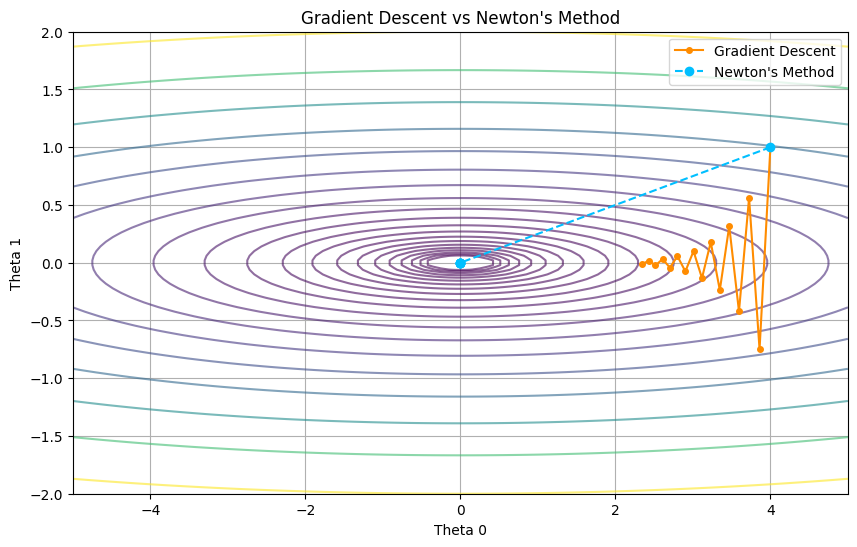

In [ ]:
# Section 1

import numpy as np
import matplotlib.pyplot as plt

# Hessian matrix (shows the curvature in each direction)
H = np.array([[1.0, 0.0],
              [0.0, 50.0]])

def cost_func(theta):
    # f(theta) = 0.5 * theta^T H theta
    return 0.5 * (theta.T @ H @ theta)

def gradient(theta):
    # grad f(theta) = H theta
    return H @ theta

def gradient_descent(init_theta, lr, n_iters):
    # Gradient Descent steps (save all points)
    theta = init_theta.copy()
    path = [theta.copy()]

    for _ in range(n_iters):
        theta -= lr * gradient(theta)
        path.append(theta.copy())

    return np.array(path)

def newtons_method(init_theta, n_iters):
    # Newton steps (save all points)
    theta = init_theta.copy()
    path = [theta.copy()]

    H_inv = np.linalg.inv(H)  # constant inverse

    for _ in range(n_iters):
        theta -= H_inv @ gradient(theta)
        path.append(theta.copy())

    return np.array(path)

# Start point
init_theta = np.array([4.0, 1.0])

# Get paths
gd_path = gradient_descent(init_theta, lr=0.035, n_iters=15)
nm_path = newtons_method(init_theta, n_iters=5)

# Make contour grid (same result, just a shorter way)
x_vals = np.linspace(-5, 5, 100)
y_vals = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(x_vals, y_vals)

# Compute Z without loops (still exactly same function values)
Z = 0.5 * (H[0, 0] * X**2 + H[1, 1] * Y**2)

plt.figure(figsize=(10, 6))

# Contour plot
plt.contour(X, Y, Z, levels=np.logspace(-1, 2, 20),
            cmap='viridis', alpha=0.6)

# Paths (colors already changed)
plt.plot(gd_path[:, 0], gd_path[:, 1],
         'o-', label='Gradient Descent',
         color='darkorange', markersize=4)

plt.plot(nm_path[:, 0], nm_path[:, 1],
         'o--', label="Newton's Method",
         color='deepskyblue', markersize=6)

plt.title("Gradient Descent vs Newton's Method")
plt.xlabel("Theta 0")
plt.ylabel("Theta 1")
plt.legend()
plt.grid(True)
plt.show()


Total Parameters: 160 (Objective: < 500)
Training SGD...
Training L-BFGS...
Training CG...


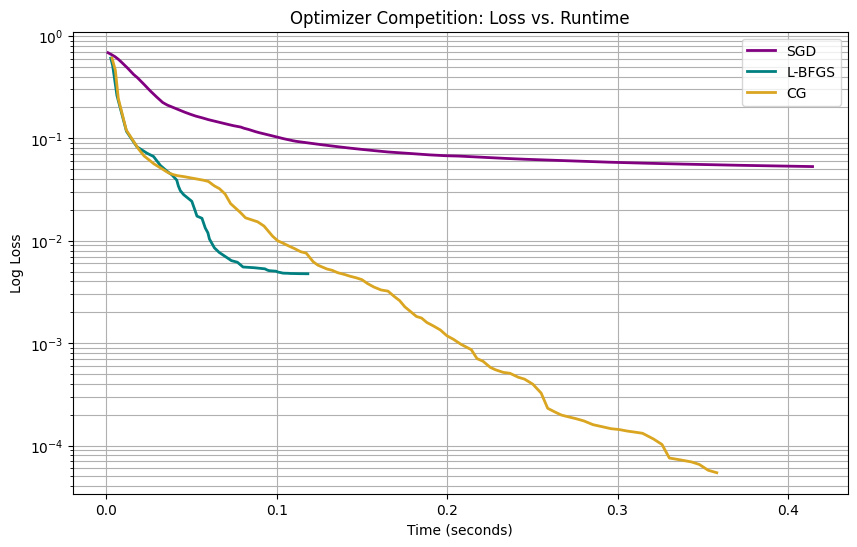

In [ ]:
# Section 2

import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize

# -----------------------------
# Data
# -----------------------------
data = load_breast_cancer()
X_raw = data.data
y = data.target.astype(float).reshape(-1, 1)  # just make it (N,1)

scaler = StandardScaler()
X_std = scaler.fit_transform(X_raw)

# add bias column
ones = np.ones((X_std.shape[0], 1))
Xb = np.concatenate([ones, X_std], axis=1)

# -----------------------------
# Tiny 2-layer NN setup
# -----------------------------
in_dim = Xb.shape[1]
hid_dim = 5
out_dim = 1

np.random.seed(42)

# pack all weights into one vector (W1 then W2)
n_params = in_dim * hid_dim + hid_dim * out_dim
w_init = (0.1 * np.random.randn(n_params)).astype(float)

print(f"Total Parameters: {n_params} (Objective: < 500)")

# -----------------------------
# Model helpers
# -----------------------------
def sigmoid(z):
    # stable sigmoid
    z = np.clip(z, -250, 250)
    return 1.0 / (1.0 + np.exp(-z))

def unpack(w):
    # split vector -> (W1, W2)
    cut = in_dim * hid_dim
    W1 = w[:cut].reshape(in_dim, hid_dim)
    W2 = w[cut:].reshape(hid_dim, out_dim)
    return W1, W2

def forward(w, X):
    # forward pass
    W1, W2 = unpack(w)
    h = sigmoid(X @ W1)
    yhat = sigmoid(h @ W2)
    return yhat, h, W2  # return what we need later

def bce_loss(w, X, y):
    # binary cross entropy
    yhat, _, _ = forward(w, X)
    eps = 1e-15
    yhat = np.clip(yhat, eps, 1 - eps)
    return -np.mean(y * np.log(yhat) + (1 - y) * np.log(1 - yhat))

def bce_grad(w, X, y):
    # manual backprop (same math, just written differently)
    N = X.shape[0]
    W1, W2 = unpack(w)
    yhat, h, _ = forward(w, X)

    # dL/dz2
    d2 = (yhat - y)  # (N,1)
    gW2 = (h.T @ d2) / N

    # dL/dz1
    dh = d2 @ W2.T
    d1 = dh * (h * (1 - h))  # sigmoid'
    gW1 = (X.T @ d1) / N

    return np.r_[gW1.ravel(), gW2.ravel()]  # same as concatenate

# -----------------------------
# Logging helpers (new style)
# -----------------------------
def run_gd(w_start, lr=0.1, steps=2000, log_every=10):
    # plain full-batch GD (they call it SGD, but it's full batch here)
    w = w_start.copy()
    t0 = time.perf_counter()
    trace = []

    for step in range(steps):
        w -= lr * bce_grad(w, Xb, y)

        if step % log_every == 0:
            trace.append((time.perf_counter() - t0, bce_loss(w, Xb, y)))

    return w, np.array(trace)

def run_scipy(method):
    # scipy minimize with a callback that records (time, loss)
    t0 = time.perf_counter()
    trace = []

    def cb(wk):
        trace.append((time.perf_counter() - t0, bce_loss(wk, Xb, y)))

    minimize(fun=bce_loss,
             x0=w_init.copy(),
             args=(Xb, y),
             jac=bce_grad,
             method=method,
             callback=cb)

    return np.array(trace)

# -----------------------------
# Train and collect histories
# -----------------------------
history = {}

print("Training SGD...")
_, history["SGD"] = run_gd(w_init, lr=0.1, steps=2000, log_every=10)

print("Training L-BFGS...")
history["L-BFGS"] = run_scipy("L-BFGS-B")

print("Training CG...")
history["CG"] = run_scipy("CG")

# -----------------------------
# Plot
# -----------------------------
plt.figure(figsize=(10, 6))

# different colors, fixed and clear
style = {
    "SGD":   dict(color="purple",    linewidth=2),
    "L-BFGS": dict(color="teal",      linewidth=2),
    "CG":    dict(color="goldenrod",  linewidth=2),
}

for name in ("SGD", "L-BFGS", "CG"):
    pts = history.get(name, None)
    if pts is not None and len(pts) > 0:
        plt.plot(pts[:, 0], pts[:, 1], label=name, **style[name])

plt.xlabel("Time (seconds)")
plt.ylabel("Log Loss")
plt.title("Optimizer Competition: Loss vs. Runtime")
plt.yscale("log")
plt.legend()
plt.grid(True, which="both", ls="-")
plt.show()


Training on: cpu

--- Hessian Memory Analysis ---
Total Parameters (N): 99,710
Hessian Shape: (99710, 99710)
Total Elements: 9.94e+09
Memory Required (Float32): 37.04 GB
CONCLUSION: IMPOSSIBLE on most consumer hardware (RAM overflow).
------------------------------


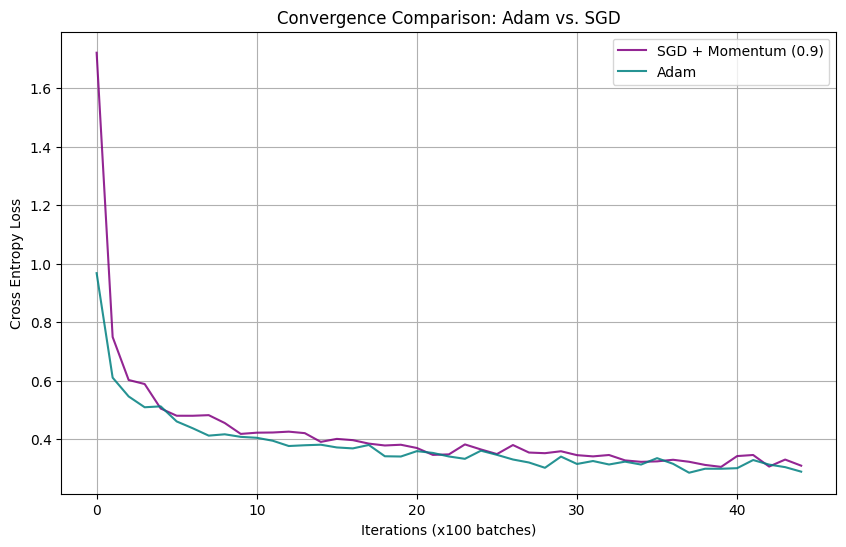

In [ ]:
# Section 3

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# simple transform: tensor + normalize
tfm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# load FashionMNIST
train_data = torchvision.datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=tfm
)
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=64, shuffle=True
)

# choose device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Training on: {device}")

class DeepNet(nn.Module):
    def __init__(self):
        super().__init__()

        # fully connected layers
        self.l1 = nn.Linear(784, 100)
        self.l2 = nn.Linear(100, 100)
        self.l3 = nn.Linear(100, 100)
        self.out = nn.Linear(100, 10)
        self.act = nn.ReLU()

    def forward(self, x):
        # flatten image
        x = x.view(x.size(0), -1)
        x = self.act(self.l1(x))
        x = self.act(self.l2(x))
        x = self.act(self.l3(x))
        x = self.out(x)
        return x

model = DeepNet().to(device)

# count total parameters
n_params = sum(p.numel() for p in model.parameters())
print(f"\n--- Hessian Memory Analysis ---")
print(f"Total Parameters (N): {n_params:,}")

# Hessian size estimate
hess_elems = n_params ** 2
mem_gb = (hess_elems * 4) / (1024 ** 3)

print(f"Hessian Shape: ({n_params}, {n_params})")
print(f"Total Elements: {hess_elems:.2e}")
print(f"Memory Required (Float32): {mem_gb:.2f} GB")

if mem_gb > 32:
    print("CONCLUSION: IMPOSSIBLE on most consumer hardware (RAM overflow).")
else:
    print("CONCLUSION: Very expensive to compute.")

print("-" * 30)

def train_model(opt_name, net_class, epochs=5):
    # train model with chosen optimizer
    net = net_class().to(device)
    loss_fn = nn.CrossEntropyLoss()

    if opt_name == "SGD_Momentum":
        opt = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
    elif opt_name == "Adam":
        opt = optim.Adam(net.parameters(), lr=0.001)

    loss_hist = []

    for _ in range(epochs):
        acc_loss = 0.0
        for i, batch in enumerate(train_loader):
            imgs, labels = batch
            imgs, labels = imgs.to(device), labels.to(device)

            opt.zero_grad()
            logits = net(imgs)
            loss = loss_fn(logits, labels)
            loss.backward()
            opt.step()

            acc_loss += loss.item()

            # save avg loss every 100 batches
            if i % 100 == 99:
                loss_hist.append(acc_loss / 100)
                acc_loss = 0.0

    return loss_hist

sgd_loss = train_model("SGD_Momentum", DeepNet)
adam_loss = train_model("Adam", DeepNet)

plt.figure(figsize=(10, 6))
plt.plot(sgd_loss, label="SGD + Momentum (0.9)", color="purple", alpha=0.85)
plt.plot(adam_loss, label="Adam", color="teal", alpha=0.85)
plt.title("Convergence Comparison: Adam vs. SGD")
plt.xlabel("Iterations (x100 batches)")
plt.ylabel("Cross Entropy Loss")
plt.legend()
plt.grid(True)
plt.show()


Covariance Matrix of X:
 [[0.08534424 0.08468374]
 [0.08468374 0.08646821]]


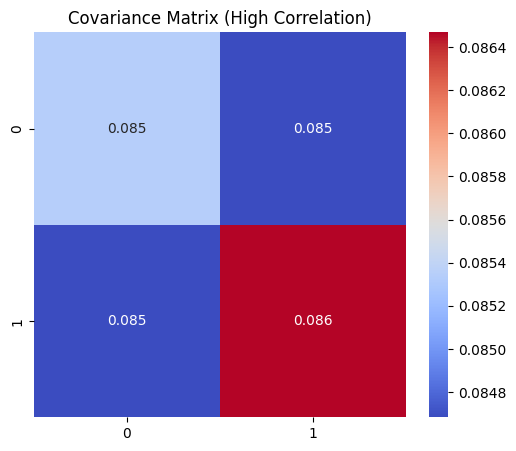


Check Orthogonality (Q.T @ Q):
[[ 1. -0.]
 [-0.  1.]]


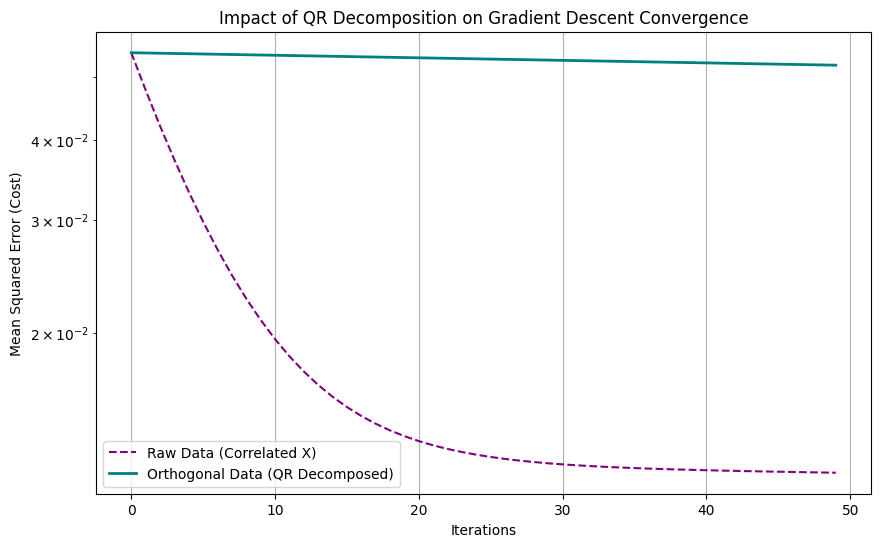

In [1]:
# Section 4

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)
n = 1000

# make 2 correlated features
f1 = np.random.rand(n, 1)
f2 = f1 + np.random.normal(0, 0.05, (n, 1))

X = np.hstack((f1, f2))

# center data (mean=0)
X -= X.mean(axis=0)

# build y with noise
th_true = np.array([[2], [-3]])
y = X @ th_true + np.random.normal(0, 0.1, (n, 1))

# covariance (shows correlation)
cov = np.cov(X, rowvar=False)
print("Covariance Matrix of X:\n", cov)

plt.figure(figsize=(6, 5))
sns.heatmap(cov, annot=True, cmap='coolwarm')
plt.title("Covariance Matrix (High Correlation)")
plt.show()

# QR decomposition (Q has orthonormal columns)
Q, _ = np.linalg.qr(X)

print("\nCheck Orthogonality (Q.T @ Q):")
print(np.round(Q.T @ Q, 2))

def train_linreg(Xf, yv, lr=0.1, iters=100):
    # GD for linear regression
    m, d = Xf.shape
    th = np.zeros((d, 1))
    loss_hist = []

    for _ in range(iters):
        yhat = Xf @ th              # prediction
        err = yhat - yv             # error
        g = (Xf.T @ err) / m        # gradient
        th -= lr * g                # update

        # MSE cost
        loss_hist.append((err.T @ err).item() / (2 * m))

    return loss_hist

loss_X = train_linreg(X, y, lr=0.5, iters=50)
loss_Q = train_linreg(Q, y, lr=0.5, iters=50)

plt.figure(figsize=(10, 6))

# new colors (not red/blue)
plt.plot(loss_X, label='Raw Data (Correlated X)', color='purple', linestyle='--')
plt.plot(loss_Q, label='Orthogonal Data (QR Decomposed)', color='teal', linewidth=2)

plt.xlabel('Iterations')
plt.ylabel('Mean Squared Error (Cost)')
plt.title('Impact of QR Decomposition on Gradient Descent Convergence')
plt.legend()
plt.grid(True)
plt.yscale('log')
plt.show()


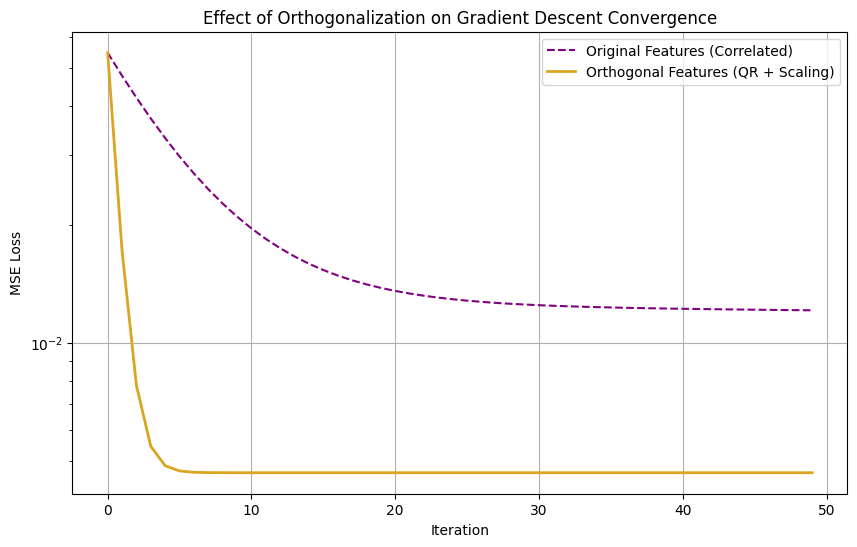

In [5]:
# Section 5

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)
n = 1000

# make 2 correlated features
f1 = np.random.rand(n, 1)
f2 = f1 + np.random.normal(0, 0.05, (n, 1))

X = np.hstack((f1, f2))

# center data
X -= X.mean(axis=0)

# build y with noise
th_true = np.array([[2], [-3]])
y = X @ th_true + np.random.normal(0, 0.1, (n, 1))

# QR decomposition
Q, _ = np.linalg.qr(X)

# scaled Q (same columns, just scaled)
Q_sc = Q * np.sqrt(n)

def train_linreg(Xf, yv, lr, iters):
    # GD for linear regression
    m, d = Xf.shape
    th = np.zeros((d, 1))
    hist = []

    for _ in range(iters):
        err = (Xf @ th) - yv              # error
        th -= (lr / m) * (Xf.T @ err)     # update
        hist.append((err.T @ err).item() / (2 * m))  # MSE cost

    return hist

loss_raw = train_linreg(X, y, lr=0.5, iters=50)
loss_orth = train_linreg(Q_sc, y, lr=0.5, iters=50)

plt.figure(figsize=(10, 6))

# new colors (still distinct)
plt.plot(loss_raw, label='Original Features (Correlated)', color='purple', linestyle='--')
plt.plot(loss_orth, label='Orthogonal Features (QR + Scaling)', color='goldenrod', linewidth=2)

plt.xlabel('Iteration')
plt.ylabel('MSE Loss')
plt.title('Effect of Orthogonalization on Gradient Descent Convergence')
plt.legend()
plt.grid(True)
plt.yscale('log')
plt.show()
